In [136]:
from sklearn.externals import joblib
import seaborn as sns
sns.set_context("paper", rc={"font.size":150, "axes.titlesize":15, "axes.labelsize":15})   
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import scipy
import pprint
import sparse
from itertools import product
import os
import glob

# check model

In [166]:
def check_model(exp_names, task_dirs, runnames, no_cohort_specific=True, verbose=True):
    '''
    check the result of models
    returns result, val_best_names, val_best
    where result is a df after choosing among validations
    '''
    if type(task_dirs) is str:
        task_dirs = [task_dirs]
        
    pds = {}
    for exp_name in exp_names:
        pd_idx = 0
        pd_dict = {}
        for task_dir, run in product(task_dirs, runnames): 
            try: # figure out what's wrong with somd of the runs
                fn = os.path.join(
                        task_dir,
                        'logs/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))
                pd_dict[pd_idx] = np.load(fn)
                if no_cohort_specific:
                    pd_dict[run] = pd_dict[run][-1:]
            except:
                if verbose:
                    print("{} missing run {}".format(exp_name, run))
                pd_idx += 1
                continue
            pd_idx += 1
        
        try:
            df = pd.DataFrame.from_dict(pd_dict)
        except Exception as error:
            print(exp_name)
            pprint.pprint(pd_dict)
            raise error
        df = df.rename({len(df.index)-1: 'micro auc'}, axis='index')    
        pds[exp_name] = df.transpose()

    for exp_name in exp_names:
        if verbose:
            print('\n' + exp_name)
            print(pds[exp_name].describe().round(3))
    
    ### second part: choose from best validation 
    pd_dict = {}
    val_best = {}
    val_best_name = {}
    for exp_name in exp_names:
        for task_dir, run in product(task_dirs, runnames):
            val_fn = os.path.join(
                        task_dir,
                        'logs/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name))                
            test_fn = os.path.join(
                         task_dir,
                         'logs/results/test_auc_on_{}_single_{}.npy'.format(run, exp_name))                
            
            try: # figure out what's wrong with some of the runs
                val_micro_auc = np.load(val_fn)[-1]
                np.load(test_fn)
            except:
                if verbose:
                    print("{} missing run {}".format(exp_name, run))
                continue

            if not val_best.get(exp_name) or val_best[exp_name] < val_micro_auc:
                val_best[exp_name] = val_micro_auc
                val_best_name[exp_name] = test_fn

                pd_dict[exp_name] = np.load(val_best_name[exp_name])
                if no_cohort_specific:
                    pd_dict[exp_name] = pd_dict[exp_name][-1:]

    df = pd.DataFrame.from_dict(pd_dict)
    df = df.rename({len(df.index)-1: 'micro auc'}, axis='index')    
    return df, val_best_name, val_best    

In [168]:
exp_names = ['moe_exp', 'global_exp', 
             'mtl_od', 'mtl_oi', 
             'mtl_val_curve', 
             'snapshot_val_curve',
             'snapshot_od', 'snapshot_oi']
task_dir = '/data7/jiaxuan/mortality/'
runnames = list(range(30))
result, val_best_name, val_best = check_model(exp_names, task_dir, runnames,
                                             verbose=False)

pprint.pprint(val_best)
pprint.pprint(val_best_name)
print(task_dir)
result.round(3)

{'global_exp': 0.8437174335134856,
 'moe_exp': 0.8455584483319506,
 'mtl_od': 0.8378478129716918,
 'mtl_oi': 0.8427070761090684,
 'mtl_val_curve': 0.9160600826752332,
 'snapshot_od': 0.8434242213745031,
 'snapshot_oi': 0.8393970221428116,
 'snapshot_val_curve': 0.921908109433654}
{'global_exp': '/data7/jiaxuan/mortality/logs/results/test_auc_on_25_single_global_exp.npy',
 'moe_exp': '/data7/jiaxuan/mortality/logs/results/test_auc_on_13_single_moe_exp.npy',
 'mtl_od': '/data7/jiaxuan/mortality/logs/results/test_auc_on_2_single_mtl_od.npy',
 'mtl_oi': '/data7/jiaxuan/mortality/logs/results/test_auc_on_4_single_mtl_oi.npy',
 'mtl_val_curve': '/data7/jiaxuan/mortality/logs/results/test_auc_on_23_single_mtl_val_curve.npy',
 'snapshot_od': '/data7/jiaxuan/mortality/logs/results/test_auc_on_5_single_snapshot_od.npy',
 'snapshot_oi': '/data7/jiaxuan/mortality/logs/results/test_auc_on_7_single_snapshot_oi.npy',
 'snapshot_val_curve': '/data7/jiaxuan/mortality/logs/results/test_auc_on_19_single_

,global_exp,moe_exp,mtl_od,mtl_oi,mtl_val_curve,snapshot_od,snapshot_oi,snapshot_val_curve
micro auc,0.849,0.847,0.839,0.846,0.839,0.845,0.846,0.814


In [169]:
exp_names = ['moe_exp', 'global_exp', 
             'mtl_od', 'mtl_oi', 
             'mtl_val_curve', 'snapshot_val_curve',
             'snapshot_od', 'snapshot_oi'
            ]
task_dir = 'eicu_mixture_of_experts_project/ARF4/'
runnames = list(range(30))
result, val_best_name, val_best = check_model(exp_names, task_dir, runnames,
                                              verbose=False)

pprint.pprint(val_best)
pprint.pprint(val_best_name)
print(task_dir)
result.round(3)

{'global_exp': 0.8298258015361704,
 'moe_exp': 0.8307454458213637,
 'mtl_od': 0.8120486222660707,
 'mtl_oi': 0.8224654013557957,
 'mtl_val_curve': 0.9198708083578324,
 'snapshot_od': 0.8148759218656971,
 'snapshot_oi': 0.8203215663279544,
 'snapshot_val_curve': 0.9071182804721127}
{'global_exp': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_22_single_global_exp.npy',
 'moe_exp': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_14_single_moe_exp.npy',
 'mtl_od': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_1_single_mtl_od.npy',
 'mtl_oi': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_4_single_mtl_oi.npy',
 'mtl_val_curve': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_8_single_mtl_val_curve.npy',
 'snapshot_od': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_9_single_snapshot_od.npy',
 'snapshot_oi': 'eicu_mixture_of_experts_project/ARF4/logs/results/test_auc_on_6_single_snapshot_oi.npy',


,global_exp,moe_exp,mtl_od,mtl_oi,mtl_val_curve,snapshot_od,snapshot_oi,snapshot_val_curve
micro auc,0.825,0.824,0.809,0.817,0.809,0.805,0.807,0.771


In [170]:
exp_names = ['moe_exp', 'global_exp', 
             'mtl_od', #'mtl_oi', 
             'mtl_val_curve', 'snapshot_val_curve',
             'snapshot_od', #'snapshot_oi'
            ]
task_dir = 'eicu_mixture_of_experts_project/Shock4/'
runnames = list(range(30))
result, val_best_name, val_best = check_model(exp_names, task_dir, runnames,
                                              verbose=False)

pprint.pprint(val_best)
pprint.pprint(val_best_name)
print(task_dir)
result.round(3)

{'global_exp': 0.856037594316961,
 'moe_exp': 0.8571566666957513,
 'mtl_od': 0.8433405489758097,
 'mtl_val_curve': 0.9227484168023731,
 'snapshot_od': 0.8344714429513431,
 'snapshot_val_curve': 0.9372857550420262}
{'global_exp': 'eicu_mixture_of_experts_project/Shock4/logs/results/test_auc_on_16_single_global_exp.npy',
 'moe_exp': 'eicu_mixture_of_experts_project/Shock4/logs/results/test_auc_on_10_single_moe_exp.npy',
 'mtl_od': 'eicu_mixture_of_experts_project/Shock4/logs/results/test_auc_on_6_single_mtl_od.npy',
 'mtl_val_curve': 'eicu_mixture_of_experts_project/Shock4/logs/results/test_auc_on_18_single_mtl_val_curve.npy',
 'snapshot_od': 'eicu_mixture_of_experts_project/Shock4/logs/results/test_auc_on_23_single_snapshot_od.npy',
 'snapshot_val_curve': 'eicu_mixture_of_experts_project/Shock4/logs/results/test_auc_on_19_single_snapshot_val_curve.npy'}
eicu_mixture_of_experts_project/Shock4/


,global_exp,moe_exp,mtl_od,mtl_val_curve,snapshot_od,snapshot_val_curve
micro auc,0.859,0.857,0.847,0.839,0.844,0.842


# small pct models

In [125]:
exp_names = ['pct{}_0_moe_exp', 'pct{}_0_global_exp', 
             'pct{}_0_mtl_od', 'pct{}_0_mtl_oi', 
             'pct{}_0_mtl_val_curve', 'pct{}_0_snapshot_val_curve',
             'pct{}_0_snapshot_od', # 'pct{}_0_snapshot_oi' # not ok b/c it uses the good snapshot model
            ]
task_dir = 'eicu_mixture_of_experts_project/mortality/'
runnames = list(range(30))

results = []
pcts = [1, 5, 10, 20, 30] 
for pct in pcts:
    new_exp_names = [exp_name.format(pct) for exp_name in exp_names]
    result, val_best_name, val_best = check_model(new_exp_names, task_dir, runnames, 
                                                  verbose=False)
    # pprint.pprint(val_best)
    # pprint.pprint(val_best_name)
    results.append(result[new_exp_names].values.ravel())

results = pd.DataFrame(np.array(results))
results = results.rename(dict((i, p) for i,p in enumerate(pcts)), axis=0)
results = results.rename(dict((i, "_".join(m.split('pct')[1].split('_')[2:])) for i, m in enumerate(exp_names)), axis=1)

#new_row = pd.Series(data={'moe_exp': 0.847, 'global_exp': 0.849, 'mtl_od': 0.846}, name=100)
#results = results.append(new_row)
results.round(3)

,moe_exp,global_exp,mtl_od,mtl_oi,mtl_val_curve,snapshot_val_curve,snapshot_od
1,0.752,0.756,0.741,0.729,0.691,0.826,0.747
5,0.791,0.788,0.775,0.782,0.724,0.804,0.775
10,0.803,0.803,0.789,0.799,0.793,0.835,0.792
20,0.817,0.819,0.806,0.817,0.806,0.821,0.789
30,0.830,0.828,0.826,0.823,0.793,0.809,0.816


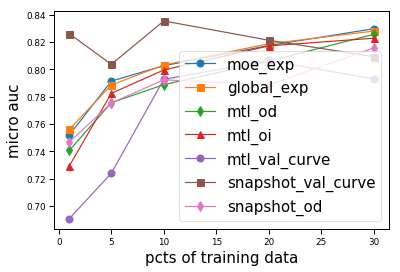

In [126]:
styles = ['-o', '-s', '-d', '-^']
i = 0
for label in results.columns:
# for label in ['global_exp', 'moe_exp', 'mtl_od', 'mtl_oi']:
#for label in ['global_exp', 'snapshot_val_curve', 'mtl_val_curve']:
#for label in ['global_exp', 'snapshot_od', 'snapshot_oi']:
    style = styles[i % len(styles)]
    i += 1
    plt.plot(results.index, results[label], style, ms=7, label=label)

plt.legend(fontsize=15)
plt.xlabel('pcts of training data', fontsize=15)
plt.ylabel('micro auc', fontsize=15)
# plt.savefig('mortality_small_data2.png')
plt.show()

In [123]:
exp_names = ['pct{}_0_moe_exp', 'pct{}_0_global_exp', 
             'pct{}_0_mtl_od', # 'pct{}_0_mtl_oi', 
             'pct{}_0_mtl_val_curve', 'pct{}_0_snapshot_val_curve',
             'pct{}_0_snapshot_od', # 'pct{}_0_snapshot_oi'
            ]
task_dir = 'eicu_mixture_of_experts_project/ARF4/'
runnames = list(range(30))

results = []
pcts = [1, 5, 10, 20, 30]
for pct in pcts:
    new_exp_names = [exp_name.format(pct) for exp_name in exp_names]
    result, val_best_name, val_best = check_model(new_exp_names, task_dir, runnames, 
                                                  verbose=False)
    # pprint.pprint(val_best)
    # pprint.pprint(val_best_name)
    results.append(result[new_exp_names].values.ravel())

results = pd.DataFrame(np.array(results))
results = results.rename(dict((i, p) for i,p in enumerate(pcts)), axis=0)
results = results.rename(dict((i, "_".join(m.split('pct')[1].split('_')[2:])) for i, m in enumerate(exp_names)), axis=1)

#new_row = pd.Series(data={'moe_exp': 0.847, 'global_exp': 0.849, 'mtl_od': 0.846}, name=100)
#results = results.append(new_row)
results.round(3)

,moe_exp,global_exp,mtl_od,mtl_val_curve,snapshot_val_curve,snapshot_od
1,0.657,0.658,0.648,0.634,0.811,0.642
5,0.728,0.731,0.718,0.707,0.805,0.727
10,0.763,0.767,0.753,0.757,0.767,0.737
20,0.785,0.787,0.780,0.781,0.809,0.765
30,0.798,0.799,0.787,0.776,0.814,0.787


In [122]:
exp_names = ['pct{}_0_moe_exp', 'pct{}_0_global_exp', 
             'pct{}_0_mtl_od', # 'pct{}_0_mtl_oi', 
             'pct{}_0_mtl_val_curve', 'pct{}_0_snapshot_val_curve',
             'pct{}_0_snapshot_od', # 'pct{}_0_snapshot_oi' # not ok b/c it uses the good snapshot model
            ]
task_dir = 'eicu_mixture_of_experts_project/Shock4/'
runnames = list(range(30))

results = []
pcts = [1]#, 5]#, 10, 20, 30]
for pct in pcts:
    new_exp_names = [exp_name.format(pct) for exp_name in exp_names]
    result, val_best_name, val_best = check_model(new_exp_names, task_dir, runnames, 
                                                  verbose=False)
    # pprint.pprint(val_best)
    # pprint.pprint(val_best_name)
    results.append(result[new_exp_names].values.ravel())

results = pd.DataFrame(np.array(results))
results = results.rename(dict((i, p) for i,p in enumerate(pcts)), axis=0)
results = results.rename(dict((i, "_".join(m.split('pct')[1].split('_')[2:])) for i, m in enumerate(exp_names)), axis=1)

#new_row = pd.Series(data={'moe_exp': 0.847, 'global_exp': 0.849, 'mtl_od': 0.846}, name=100)
#results = results.append(new_row)
results.round(3)

,moe_exp,global_exp,mtl_od,mtl_val_curve,snapshot_val_curve,snapshot_od
1,0.736,0.734,0.717,0.62,0.784,0.71


# performance per group evaluation

In [135]:
exp_names = ['moe_exp', 'global_exp', 
             'MTL_careunit_exp', 
             'careunit_feature_exp',
             'snapshot_careunit_exp', 
             'separate_careunit_exp']

task_dir = ['/data7/jiaxuan/mimic_mixture_of_experts_project/previous_result',
            '/data7/jiaxuan/mimic_mixture_of_experts_project/result']
runnames = list(range(30))

runnames = list(range(30))
result, val_best_name, val_best = check_model(exp_names, task_dir, runnames,
                                              verbose=False, no_cohort_specific=False)

#pprint.pprint(val_best)
# pprint.pprint(val_best_name)
print(task_dir)
result = result.rename({0: 'CCU', 1: 'CSRU', 2: 'MICU', 3: 'SICU', 4: 'TSICU', 5: 'Macro', 6: 'Micro'}, axis='index')    
result.round(3)

['/data7/jiaxuan/mimic_mixture_of_experts_project/previous_result', '/data7/jiaxuan/mimic_mixture_of_experts_project/result']


,MTL_careunit_exp,careunit_feature_exp,global_exp,moe_exp,separate_careunit_exp,snapshot_careunit_exp
CCU,0.884,0.876,0.886,0.893,0.845,0.866
CSRU,0.876,0.888,0.901,0.888,0.923,0.884
MICU,0.819,0.811,0.816,0.809,0.810,0.814
SICU,0.854,0.859,0.856,0.848,0.814,0.846
TSICU,0.852,0.843,0.849,0.840,0.819,0.843
Macro,0.857,0.856,0.861,0.856,0.842,0.851
micro auc,0.868,0.863,0.864,0.858,0.846,0.853


# generating random subset of data

In [19]:
def generate_pct_data(pct, task_dir, num_runs):
    '''
    Given 'eicu_mixture_of_experts_project/eICU_data/mortality/'
    Save in 'eicu_mixture_of_experts_project/eICU_data/mortality/pct_{pct}_train_indices/'
    '''
    np.random.seed(42)    
    pct = int(pct)
    assert pct > 0 and pct <= 100, "pct need to be in (0, 100]"
    assert os.path.exists(os.path.join(task_dir, 'data')), "{} does not exist".format(os.path.join(task_dir, 'data'))
    
    os.system('mkdir -p {}/pct_{}_train_indices'.format(task_dir, pct))
    train_choices = joblib.load(task_dir + '/train_idx.pkl')
    n_new = int(len(train_choices) * pct / 100)
    for i in range(num_runs):
        indices = np.random.choice(train_choices, size=n_new, replace=False)
        save_fn = "{}/pct_{}_train_indices/{}.pkl".format(task_dir, pct, i)
        joblib.dump(indices, save_fn)
    
# task_dir = 'eicu_mixture_of_experts_project/eICU_data/mortality'
task_dir = 'eicu_mixture_of_experts_project/eICU_data/Shock_4.0h_download/'
for pct in [1, 5, 10, 20, 30]:
    generate_pct_data(pct, task_dir, 30)

# plot logs

pct1_0_moe_exp


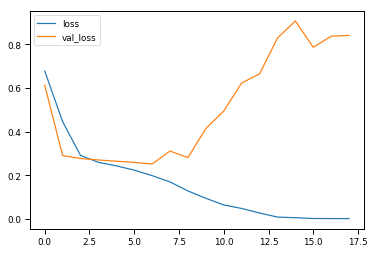

pct1_0_global_exp


IOError: [Errno 2] No such file or directory: 'eicu_mixture_of_experts_project/Shock4/logs/checkpoints/0_pct1_0_global_exp/log'

In [92]:
def plot_log(fn):
    logs = joblib.load(fn)
    loss = [item['loss'] for item in logs]
    val_loss = [item['val_loss'] for item in logs]
    plt.plot(loss, label='loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()
    plt.show()

exp_names = ['pct{}_0_moe_exp', 'pct{}_0_global_exp', 
             'pct{}_0_mtl_od', 'pct{}_0_mtl_oi', 
             'pct{}_0_mtl_val_curve', 'pct{}_0_snapshot_val_curve',
             'pct{}_0_snapshot_od', 'pct{}_0_snapshot_oi'
            ]
# task = 'mortality' # ok
# task = 'ARF4'
task = 'Shock4'
pct = 1
for expname in exp_names:
    print(expname.format(pct))
    plot_log('eicu_mixture_of_experts_project/{}/logs/checkpoints/0_{}/log'\
             .format(task, expname.format(pct)))

# large exp
# plot_log('eicu_mixture_of_experts_project/mortality/logs/checkpoints/2_moe_exp/log')
# plot_log('eicu_mixture_of_experts_project/ARF4/logs/checkpoints/9_moe_exp/log')
# plot_log('eicu_mixture_of_experts_project/Shock4/logs/checkpoints/6_moe_exp/log')

# check data

In [2]:
save_data_path = "mixture_of_experts_project/data/mortality_24/"
X = np.load(save_data_path + 'X.npy')
# jw: need to allow_pickle=True                                                                                                                                                                                 
careunits = np.load(save_data_path + 'careunits.npy', allow_pickle=True)
saps_quartile = np.load(save_data_path + 'saps_quartile.npy')
subject_ids = np.load(save_data_path + 'subject_ids.npy')
Y = np.load(save_data_path + 'Y.npy')

pd_dict = {}
all_tasks = sorted(np.unique(careunits))
for task in all_tasks:
    subset = (careunits == task)
    n_samples = sum(subset)
    n_pos_samples = sum(Y[subset])
    pd_dict[task] = {'N': n_samples, 'n': n_pos_samples, 'Class Imbalance': float(n_pos_samples) / n_samples}

df = pd.DataFrame.from_dict(pd_dict).T
df2 = pd.DataFrame.from_dict({'Overall': {'N': len(Y), 'n': sum(Y), 'Class Imbalance': float(sum(Y)) / len(Y)}}).T
df = df.append(df2)
df[['N', 'n']].astype(int)

,N,n
CCU,4888,340
CSRU,6977,136
MICU,11429,1120
SICU,5183,398
TSICU,4234,284
Overall,32711,2278


# inspect hyperparameters

In [13]:
def get_val_dfs(exp_names=['moe_exp', 'global_exp'], 
                task_dir='mixture_of_experts_project/result', 
                runnames=range(10)):
    # get validation performance
    pds = {}
    for exp_name in exp_names:
        pd_dict = {}
        for run in runnames:
            pd_dict[run] = np.load(os.path.join(
                task_dir,
                'logs/results/val_auc_on_{}_single_{}.npy'.format(run, exp_name)))
            pd_dict[run] = pd_dict[run][-1:] # only use the micro auc
        df = pd.DataFrame.from_dict(pd_dict)
        df = df.rename({len(df.index)-1: 'micro auc'}, axis='index')
        pds[exp_name] = df.transpose()

    return pds

def get_settings_df(task_dir='mixture_of_experts_project/result'):
    # plot partial dependence of all the hyper-parameters, based on validation performance
    fn = os.path.join(task_dir, 'settings/cluster_model_settings.pkl')
    cluster_settings, model_settings = joblib.load(fn)
    pd_dict = defaultdict(lambda: np.zeros(len(cluster_settings)))
    for i, setting in enumerate(zip(cluster_settings, model_settings)):
        cluster_setting, model_setting = setting

        for arg in cluster_setting:
            if type(arg) in [list, tuple]:
                k, v = arg
            else:
                k, v = arg, 1
            if k.startswith('--'):
                k = k[2:]
            elif k.startswith('-'):
                k = k[1:]

            if k == 'lr':
                k = 'log_lr'
                v = np.log10(v)
            if k == 'wd':
                k = 'log_wd'
                v = np.log10(v)
            if type(v) is str: continue
            pd_dict['cluster_' + str(k)][i] = v

        for arg in model_setting:
            if type(arg) in [list, tuple]:
                k, v = arg
            else:
                k, v = arg, 1
            if k.startswith('--'):
                k = k[2:]
            elif k.startswith('-'):
                k = k[1:]

            if k == 'lr':
                k = 'log_lr'
                v = np.log10(v)
            if k == 'wd':
                k = 'log_wd'
                v = np.log10(v)
            if type(v) is str: continue
            pd_dict['model_' + str(k)][i] = v

    settings_df = pd.DataFrame.from_dict(pd_dict)
    return settings_df

def plot_hp_dependence(val_dfs, settings_df, exp_name):
    plt.figure(figsize=(20,20))
    for i, c in enumerate(settings_df.columns):
        n = int(np.ceil(np.sqrt(len(settings_df.columns))))
        plt.subplot(n, n, i+1)
        idx = val_dfs[exp_name]['micro auc'].index
        sns.regplot(x=settings_df[c][idx], y=val_dfs[exp_name]['micro auc'], fit_reg=True)
        # plt.tight_layout()
    plt.show()

pct1_0_global_exp


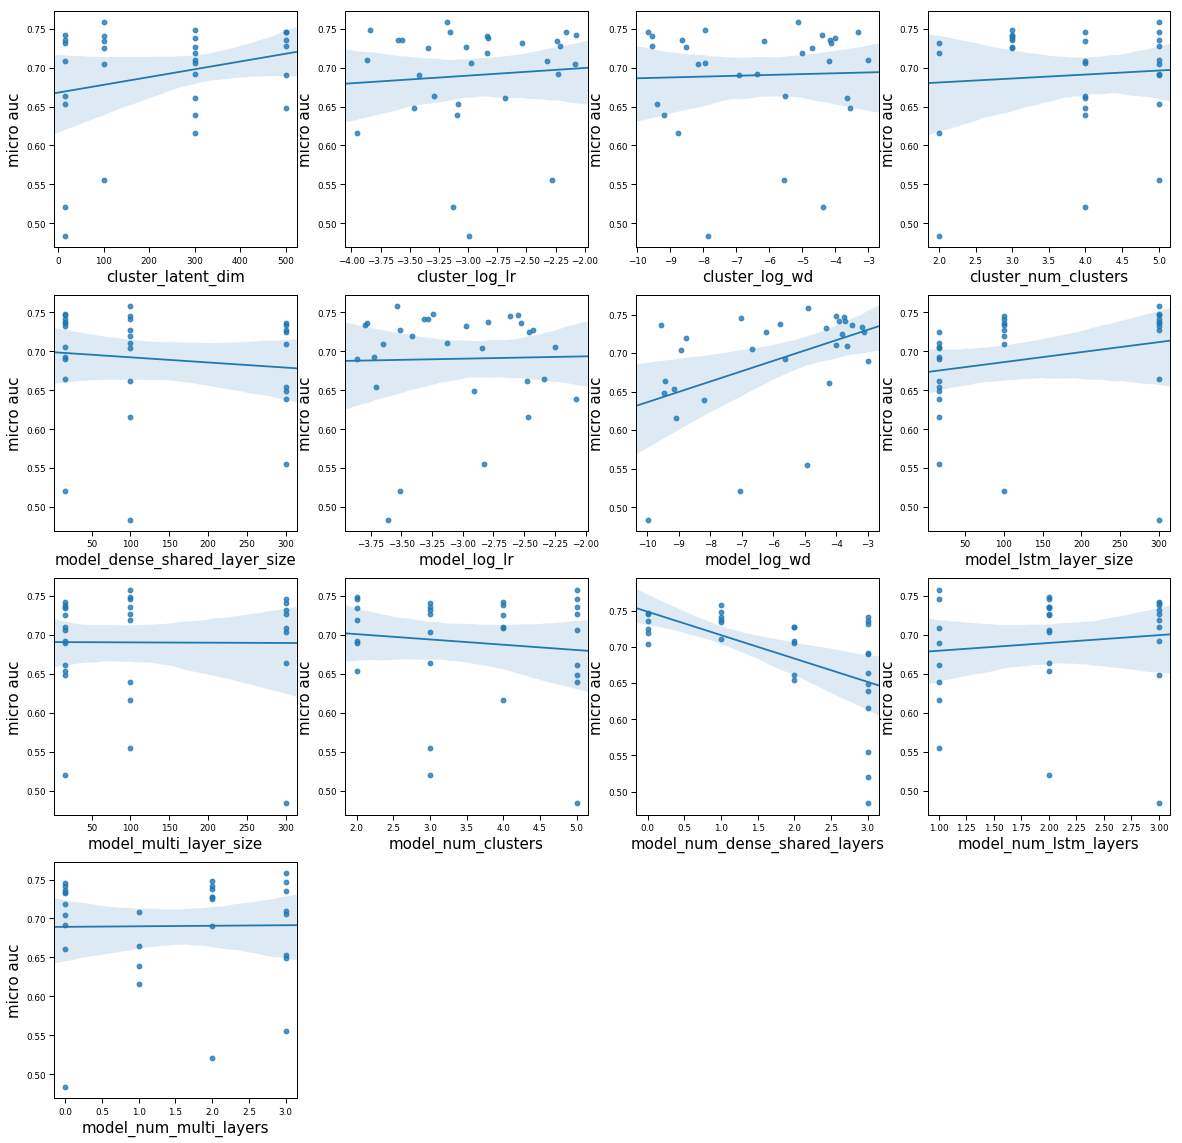

In [14]:
exp_names = ['pct1_0_global_exp'] #['global_exp']
task_dir = 'eicu_mixture_of_experts_project/mortality/'
runnames = list(range(30))

val_dfs = get_val_dfs(exp_names, task_dir, runnames)
settings_df = get_settings_df(task_dir)

for exp_name in exp_names:
    print(exp_name)
    plot_hp_dependence(val_dfs, settings_df, exp_name)

In [114]:
settings_df

,cluster_latent_dim,cluster_log_lr,cluster_log_wd,cluster_num_clusters,model_dense_shared_layer_size,model_log_lr,model_log_wd,model_lstm_layer_size,model_multi_layer_size,model_num_clusters,model_num_dense_shared_layers,model_num_lstm_layers,model_num_multi_layers
0,300.0,-3.093259,-9.190304,4.0,300.0,-2.075536,-8.200097,16.0,100.0,5.0,3.0,1.0,1.0
1,16.0,-3.125652,-4.385773,4.0,16.0,-3.509043,-7.049606,100.0,16.0,3.0,3.0,2.0,2.0
2,16.0,-2.989873,-7.843394,2.0,100.0,-3.604615,-9.994128,300.0,300.0,5.0,3.0,3.0,0.0
3,100.0,-3.184360,-5.126398,5.0,100.0,-3.532347,-4.899833,300.0,100.0,5.0,1.0,1.0,3.0
4,300.0,-3.841589,-7.941787,3.0,16.0,-3.243031,-4.022331,300.0,100.0,2.0,1.0,2.0,2.0
5,100.0,-2.237920,-6.171314,4.0,300.0,-3.796074,-3.182863,100.0,16.0,2.0,1.0,2.0,0.0
6,100.0,-2.280573,-5.554448,5.0,300.0,-2.826992,-4.946838,16.0,100.0,3.0,3.0,1.0,3.0
7,300.0,-3.864540,-3.016979,5.0,100.0,-3.127030,-4.006663,16.0,16.0,4.0,1.0,3.0,3.0
8,16.0,-2.070952,-4.404730,3.0,100.0,-3.284367,-3.926219,100.0,16.0,4.0,3.0,3.0,0.0
9,500.0,-2.158717,-9.683399,4.0,16.0,-2.548510,-3.744168,300.0,100.0,5.0,0.0,1.0,3.0
